In [10]:
import torch
import re
import os
from typing import List, Tuple, Dict

if not os.getcwd().endswith('haawron_mmaction2'):
    os.chdir('..') 
os.getcwd()

'/data/hyogun/repos/haawron_mmaction2'

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# path_pth_original = 'data/weights/timesformer/TimeSformer_divST_8x32_224_HowTo100M.pyth'
path_pth_original = 'data/weights/timesformer/TimeSformer_divST_8_224_SSv2.pyth'
pth_original = torch.load(path_pth_original, map_location=device)
pth_mmrefer = torch.load(r'data/weights/timesformer/timesformer_divST_8x32x1_15e_kinetics400_rgb-3f8e5d03.pth', map_location=device)
pth_original.keys(), pth_mmrefer.keys()

(dict_keys(['epoch', 'model_state', 'optimizer_state', 'cfg']),
 dict_keys(['meta', 'state_dict']))

* `'meta'`에는 mmaction 학습 정보가 들어가있음

In [12]:
TENSOR_DICT = Dict[str,torch.Tensor]
state_original:TENSOR_DICT = pth_original.get('state_dict', pth_original.get('model_state', pth_original))  # state_dict -> model_state -> w itself
state_mmrefer:TENSOR_DICT = pth_mmrefer['state_dict']
prev_layer_idx = None
RED, DEFAULT = '\x1b[31m', '\x1b[0m'
def write_line(i, A_tensor_name, A_tensor_shape:str, B_tensor_name, B_tensor_shape:str):
    name_width = 80 if A_tensor_name else 5
    return f'{A_tensor_name:{name_width}}  {i:3d} {A_tensor_shape:16s}\t{i:3d} {B_tensor_shape:16s}  {B_tensor_name:60}'

print(write_line(999, 'mmaction', '', 'official', ''))
for i, ((tensor_name_mmrefer, tensor_mmrefer), (tensor_name_original, tensor_original)) in enumerate(zip(state_mmrefer.items(), state_original.items())):
    msg = write_line(i, tensor_name_mmrefer, str(tuple(tensor_mmrefer.shape)), tensor_name_original, str(tuple(tensor_original.shape)))
    is_diff = tensor_mmrefer.shape != tensor_original.shape
    if is_diff:
        msg = RED + msg + DEFAULT
    layer_idx = re.findall('\.layers\.(\d+)\.', tensor_name_mmrefer)
    layer_idx = layer_idx[0] if layer_idx else None
    if layer_idx != prev_layer_idx:
        print()
    print(msg)
    prev_layer_idx = layer_idx

mmaction                                                                          999                 	999                   official                                                    
backbone.cls_token                                                                  0 (1, 1, 768)     	  0 (1, 1, 768)       model.cls_token                                             
backbone.pos_embed                                                                  1 (1, 197, 768)   	  1 (1, 197, 768)     model.pos_embed                                             
backbone.time_embed                                                                 2 (1, 8, 768)     	  2 (1, 8, 768)       model.time_embed                                            
backbone.patch_embed.projection.weight                                              3 (768, 3, 16, 16)	  3 (768, 3, 16, 16)  model.patch_embed.proj.weight                               
backbone.patch_embed.projection.bias                                  

## 이상한 부분이 block 안 쪽이랑 끄트머리밖에 없음
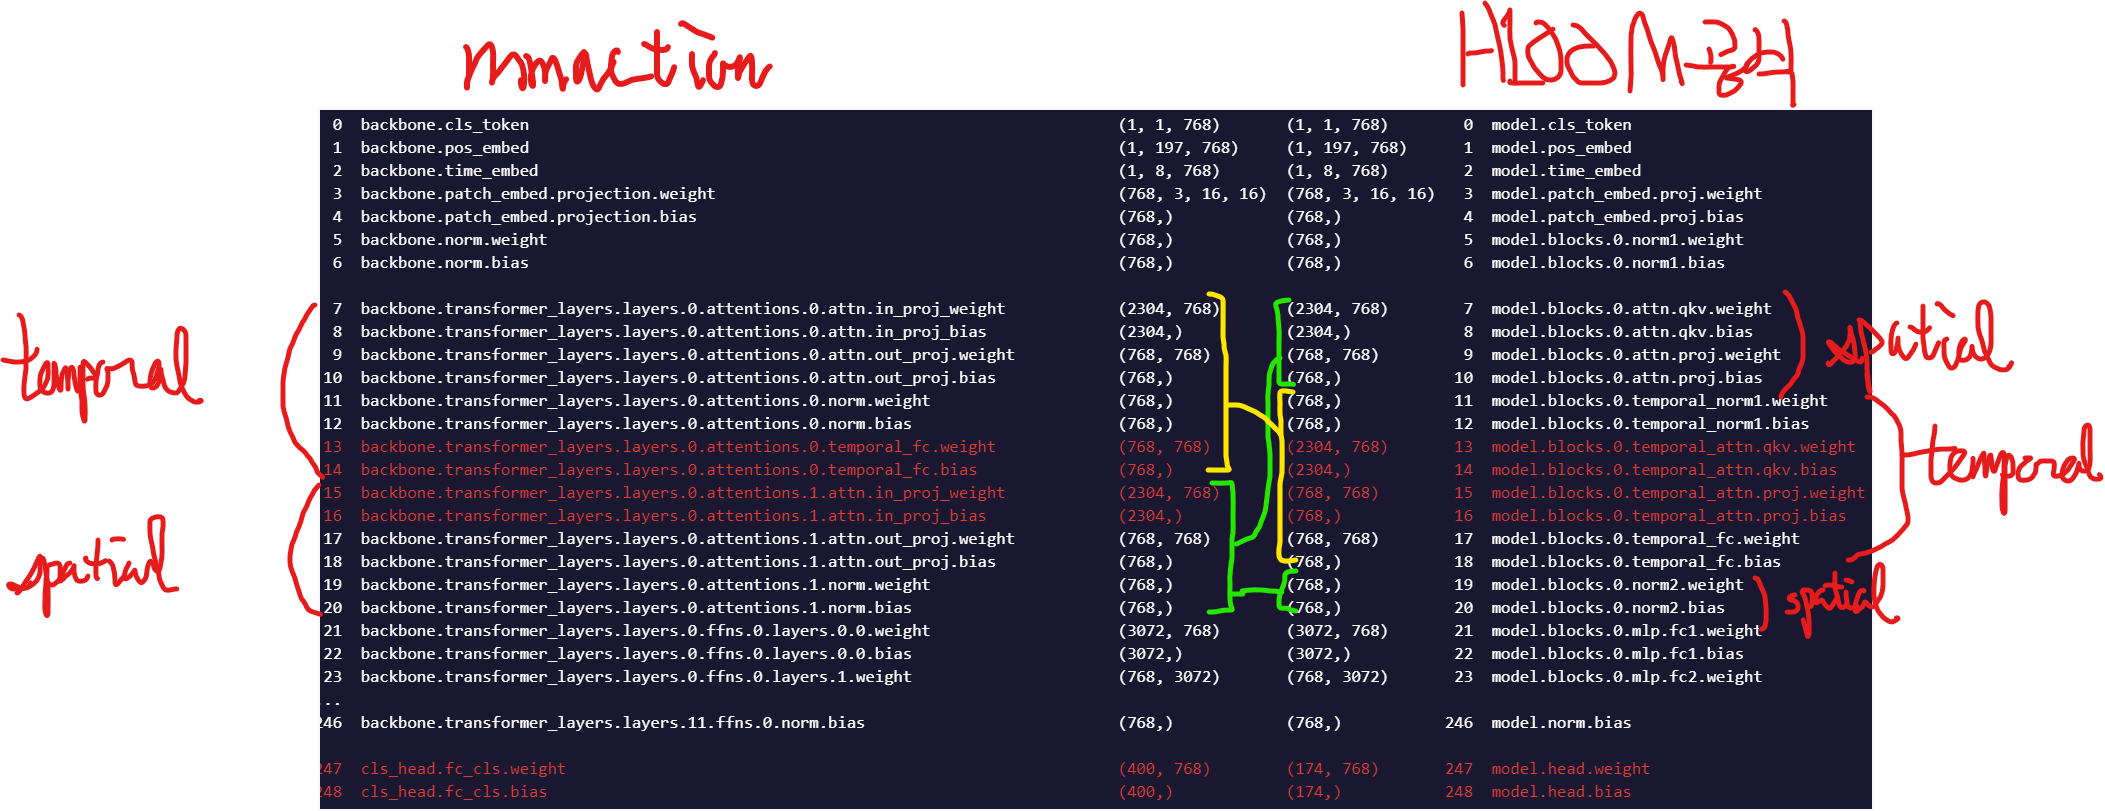
## 이렇게 이어주면 될 듯
### 끄트머리는 이름만 바꿔서 살려놓자! class 정의가 달라서 의미는 없긴 한데 호옥시 나중에 쓸 수 있음

#### TimeSFormer H100M time length 큰 모델은 time_embed가 learnable이라 안 됨
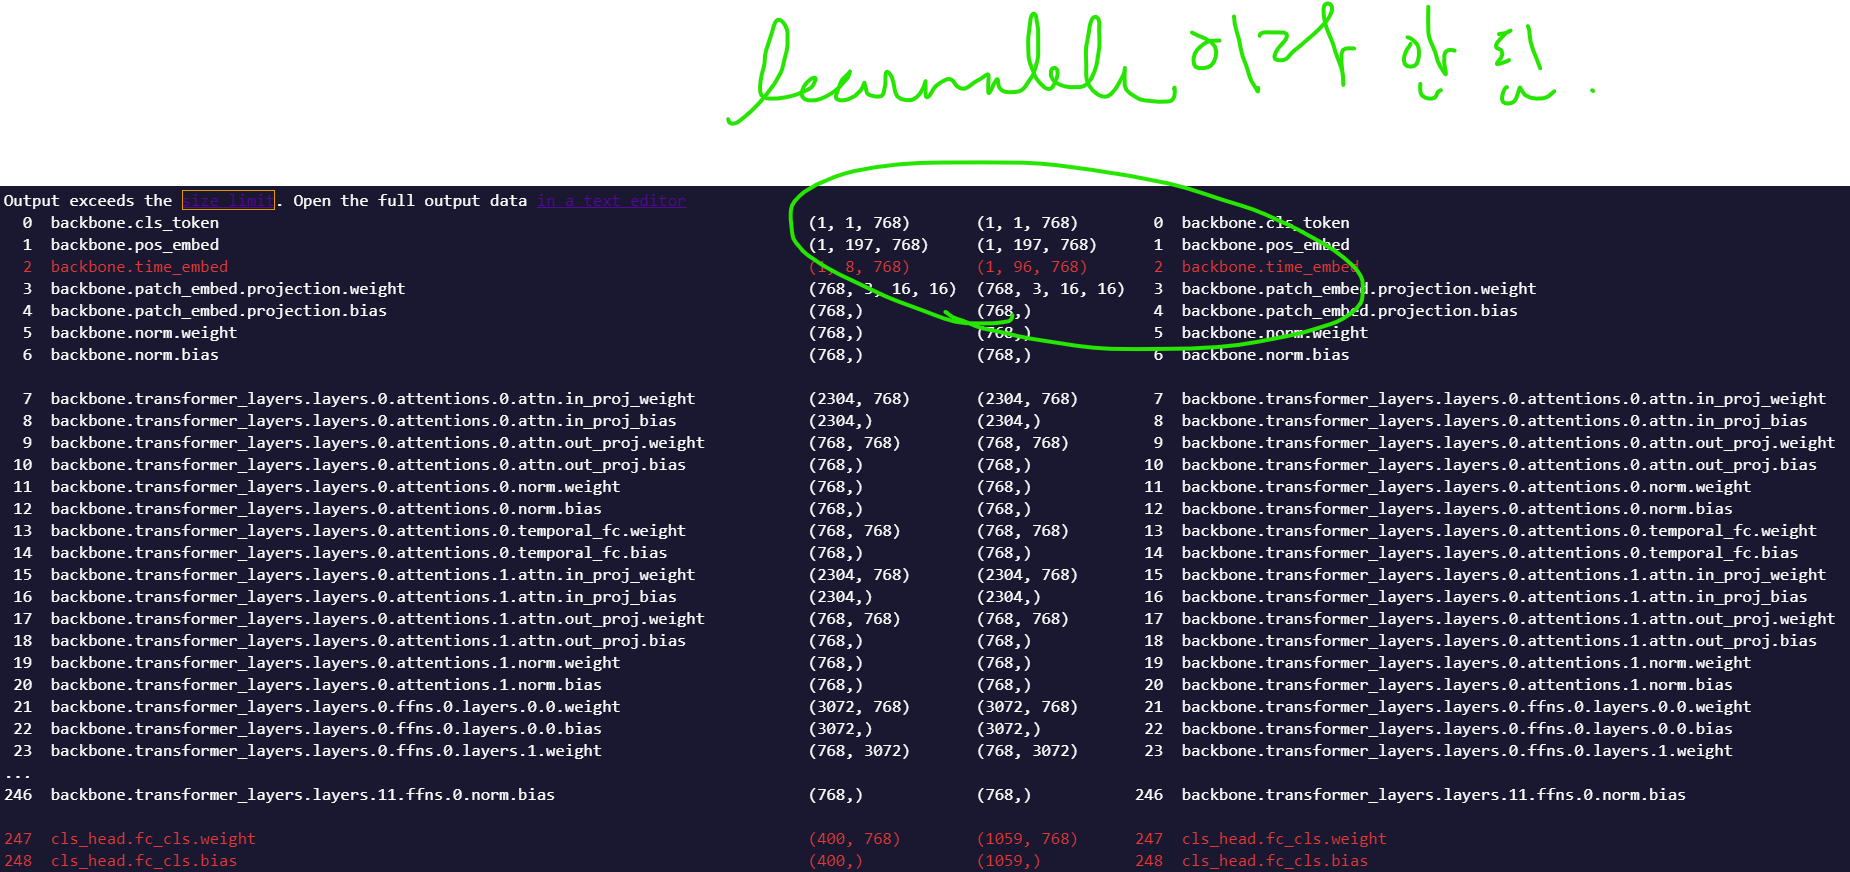

In [13]:
tensor_names_mmrefer = list(state_mmrefer.keys())
TENSOR_INFO = Tuple[str,torch.Tensor]
new_state:List[TENSOR_INFO] = []
for i, (tensor_name_original, tensor_original) in enumerate(state_original.items()):
    if re.search(r'\d+\.attn\.', tensor_name_original):
        j = i + 8
    elif re.search(r'\d+\.temporal_attn\.', tensor_name_original):
        j = i - 6
    elif re.search(r'\d+\.temporal_fc\.', tensor_name_original):
        j = i - 4
    elif re.search(r'\d+\.norm1\.(weight|bias)', tensor_name_original):
        j = i + 14
    elif re.search(r'\d+\.norm2\.(weight|bias)', tensor_name_original):
        j = i + 6
    elif re.search(r'model\.norm\.(weight|bias)', tensor_name_original):
        j = i - 240
    else:
        j = i
    new_tensor_info:TENSOR_INFO = (tensor_names_mmrefer[j], tensor_original)
    new_state.append(new_tensor_info)

# validate
tensors_original = list(state_original.values())
tensors_mmrefer = list(state_mmrefer.values())
for i, (tensor_name_new, tensor_new) in enumerate(new_state):
    shape_mmrefer, shape_new = str(tuple(state_mmrefer[tensor_name_new].shape)), str(tuple(tensor_new.shape))
    is_diff = shape_mmrefer != shape_new
    msg = write_line(i, '', shape_mmrefer, tensor_name_new, shape_new)
    if is_diff:
        msg = RED + msg + DEFAULT
    layer_idx = re.findall('\.layers\.(\d+)\.', tensor_name_mmrefer)
    layer_idx = layer_idx[0] if layer_idx else None
    if layer_idx != prev_layer_idx:
        print()
    print(msg)

tensor_names_new = [info[0] for info in new_state]
len(set(tensor_names_new)), len(tensor_names_new)

         0 (1, 1, 768)     	  0 (1, 1, 768)       backbone.cls_token                                          
         1 (1, 197, 768)   	  1 (1, 197, 768)     backbone.pos_embed                                          
         2 (1, 8, 768)     	  2 (1, 8, 768)       backbone.time_embed                                         
         3 (768, 3, 16, 16)	  3 (768, 3, 16, 16)  backbone.patch_embed.projection.weight                      
         4 (768,)          	  4 (768,)            backbone.patch_embed.projection.bias                        
         5 (768,)          	  5 (768,)            backbone.transformer_layers.layers.0.attentions.1.norm.weight
         6 (768,)          	  6 (768,)            backbone.transformer_layers.layers.0.attentions.1.norm.bias 
         7 (2304, 768)     	  7 (2304, 768)       backbone.transformer_layers.layers.0.attentions.1.attn.in_proj_weight
         8 (2304,)         	  8 (2304,)           backbone.transformer_layers.layers.0.attentions.1.at

(249, 249)

In [14]:
from pathlib import Path
p_pth_original = Path(path_pth_original)
new_name = p_pth_original.stem.replace('_divST', '').lower() + '_mmaction' + p_pth_original.suffix
p_pyth = p_pth_original.with_name(new_name)
print(p_pyth)
pth_new = pth_mmrefer.copy()
pth_new['state_dict'] = dict(new_state)
torch.save(pth_new, p_pyth)

data/weights/timesformer/timesformer_8_224_ssv2_mmaction.pyth
